### Create dataset - original images and their masks

In [ ]:
import os
from PIL import Image, ImageDraw, ImageOps

def resize_with_pad_and_create_mask(image, target_size, bboxes):
    # Calculate padding
    width, height = image.size
    ratio = min(target_size[0] / width, target_size[1] / height)
    new_size = (round(width * ratio), round(height * ratio))
    padding = (int((target_size[0] - new_size[0]) / 2), int((target_size[1] - new_size[1]) / 2))

    # Resize image with padding
    resized_image = ImageOps.pad(image.resize(new_size, Image.ANTIALIAS), target_size)

    # Create mask
    mask = Image.new('L', target_size, 0)
    draw = ImageDraw.Draw(mask)

    # effect of scaling only
    bboxes = [(int(bbox[0] * ratio), 
        int(bbox[1] * ratio), 
        int(bbox[2] * ratio), 
        int(bbox[3] * ratio)) 
        for bbox in bboxes]

    # effect of padding
    bboxes = [(bbox[0] + padding[0], 
        bbox[1] + padding[1], 
        bbox[2] + padding[0], 
        bbox[3] + padding[1]) 
        for bbox in bboxes]

    for bbox in bboxes:
        draw.rectangle(bbox, fill=255)
    
    
    return resized_image, mask    



def main(annotation_file, dir_for_orig_images, output_dir):
    prefix = 'WIDER_train/WIDER_train/images/'
    with open(annotation_file, 'r') as f:
        lines = f.readlines()

    i = 10424  # line number
    image_counter = 280   # image number
    while(i < len(lines)):
        print(image_counter)
        file_name = prefix + lines[i].strip()
        num_bboxes = max(int(lines[i+1]), 1) # max is used to handle the edge case of 0 bboxes.
        
        bboxes = []
        for j in range(i+2, i+2+num_bboxes):
            line_content = lines[j].strip().split(' ')
            line_content = [int(content) for content in line_content]
            
            if(line_content[7] == 0): # check if annotation is valid
                # bbox = tuple(map(int, lines[j].strip().split(' ')))[0:4]
                bbox = line_content[0:4]
                bbox[2] += bbox[0]
                bbox[3] += bbox[1]
                bboxes.append(bbox)

                image = Image.open(file_name)
                image, mask = resize_with_pad_and_create_mask(image, (512, 512), bboxes)
                
                
                orig_filename = os.path.join(dir_for_orig_images, f"{os.path.splitext(os.path.basename(file_name))[0]}.png")
                mask_file_name = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(file_name))[0]}.png")
                
                image.save(orig_filename)
                mask.save(mask_file_name)

        i = i+2+num_bboxes
        image_counter += 1

if __name__ == "__main__":
    annotation_file = "wider_face_split/wider_face_split/wider_face_train_bbx_gt.txt"  # Path to your annotation file
    output_dir = "mask_images"  # Output directory to save mask images
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    dir_for_orig_images = "orig_images"
    if not os.path.exists(dir_for_orig_images):
        os.makedirs(dir_for_orig_images)

    main(annotation_file, dir_for_orig_images, output_dir)


## Simple resizing of masks to a very low dim or do custom resizing? 

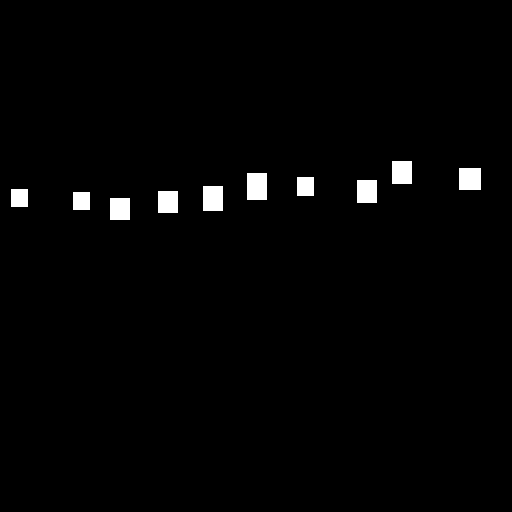

In [53]:
from torchvision import transforms
img = Image.open('mask_images/0_Parade_marchingband_1_5.png')
img

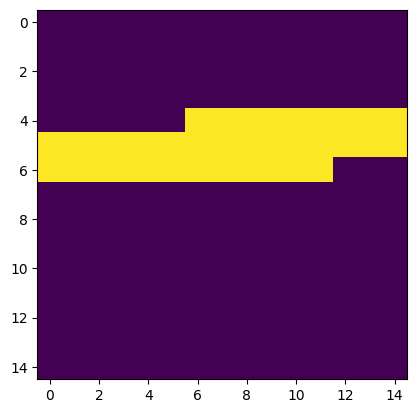

In [55]:
# Plain default resize
img = transforms.Resize((15))(img)
img_thresh = img.point( lambda p: 255 if p > 0 else 0 )
plt.imshow(img_thresh)


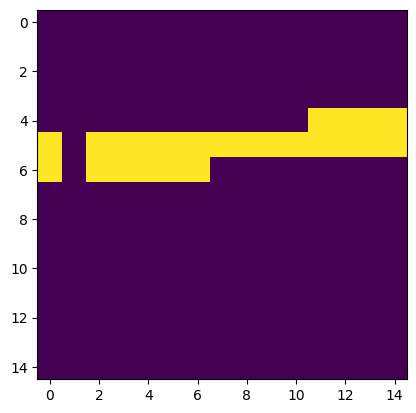

In [56]:
# Custom resizing

from PIL import Image
import numpy as np

# Function to downsize the binary image
def downsize_image(binary_image, target_size):
    original_size = binary_image.size[0]  # Assuming square image
    block_size = original_size // target_size
    downsized_image = Image.new('1', (target_size, target_size))
    
    for i in range(target_size):
        for j in range(target_size):
            block = binary_image.crop((j*block_size, i*block_size, (j+1)*block_size, (i+1)*block_size))
            if any(pix > 0 for pix in block.getdata()):
                downsized_image.putpixel((j, i), 255)
    
    return downsized_image

# Example usage
# Assuming your binary image is loaded using PIL and stored in a variable named binary_image
# and you want to downsize it to 15x15
binary_image = Image.open("mask_images/0_Parade_marchingband_1_5.png")  # Example: "example_image.png"
downsized_image = downsize_image(binary_image, 15)
plt.imshow(np.array(downsized_image))



## Find mean and std of data


In [62]:
import os
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Define the folder containing the images
folder_path = 'orig_images'

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Function to calculate mean and standard deviation
def calculate_mean_std(folder_path, transform, num_images):
    mean = 0.
    std = 0.
    count = 0
    
    for filename in os.listdir(folder_path):
        if count >= num_images:
                break
        
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
        count += 1

    mean /= num_images
    std /= num_images

    return mean, std

# Calculate mean and standard deviation
num_images = 10000
mean, std = calculate_mean_std(folder_path, transform, num_images)

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: tensor([0.3298, 0.3051, 0.2864])
Standard Deviation: tensor([0.3051, 0.2883, 0.2805])


Mean: tensor([0.3298, 0.3051, 0.2864])

Standard Deviation: tensor([0.3051, 0.2883, 0.2805])

## Run inference on a trained model

In [134]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

"""
Prerequisites 
1. Define the model class
2. Define the resize with pad transformation class
"""
class MobileNetV3WithConv(nn.Module):
    def __init__(self):
        super(MobileNetV3WithConv, self).__init__()
        
        # Load the MobileNetV3-small model
        self.mobilenet_v3 = models.mobilenet_v3_small(weights = 'DEFAULT')
        self.mobilenet_v3 = self.mobilenet_v3.features[0:9]
        self.conv = nn.Conv2d(48, 1, kernel_size=1, stride=1, padding=0, bias=False)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x):
        x = self.mobilenet_v3(x)
        x = self.conv(x)
        x = self.sigmoid(x)

        return x


class CustomResizeWithPad():
    def __init__(self, target_size = (240, 240)):
        self.target_size = target_size

    def __call__(self, image):
        # Calculate padding
        width, height = image.size
        ratio = min(self.target_size[0] / width, self.target_size[1] / height)
        new_size = (round(width * ratio), round(height * ratio))
        padding = (int((self.target_size[0] - new_size[0]) / 2), int((self.target_size[1] - new_size[1]) / 2))

        # Resize image with padding
        resized_image = ImageOps.pad(image.resize(new_size, Image.ANTIALIAS), self.target_size)
        return resized_image


# Instantiate the model
model = MobileNetV3WithConv().to(DEVICE)

# Load model weights
model_weights_path = 'segmentation_model_epoch_11.pth'
model.load_state_dict(torch.load(model_weights_path, map_location=DEVICE))

# Load image
image_path = 'orig_images/1_Handshaking_Handshaking_1_165.png'
input_img = Image.open(image_path)

# image transformation
image_transform = transforms.Compose([
    CustomResizeWithPad(target_size = (240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3298, 0.3051, 0.2864], std=[0.3051, 0.2883, 0.2805])
])

# transform image and add extra 0th dimension for batch (using unsqueeze()) to make the image dimensions compatible with PyTorch model
transformed_image = image_transform(input_img).unsqueeze(0)

# Inference
prediction = model(transformed_image).squeeze() # This is a 15x15 array (PyTorch tensor) 

C:\Users\SCP\AppData\Local\Temp\ipykernel_21892\548404306.py:49: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = ImageOps.pad(image.resize(new_size, Image.ANTIALIAS), self.target_size)


In [135]:
prediction.shape

torch.Size([15, 15])

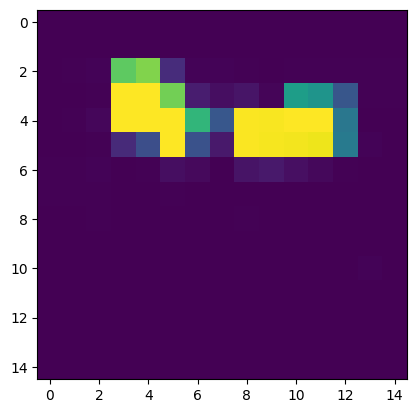

In [136]:
plt.imshow(prediction.squeeze().detach().numpy())

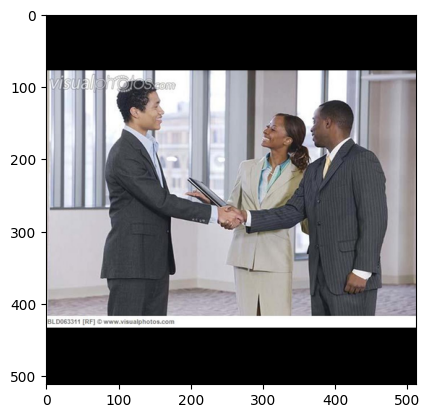

In [137]:
plt.imshow(input_img)